0:	learn: 0.7718508	test: 0.7755492	best: 0.7755492 (0)	total: 54.9ms	remaining: 54.9s
50:	learn: 0.9341362	test: 0.9390857	best: 0.9391524 (48)	total: 2.07s	remaining: 38.5s
100:	learn: 0.9340263	test: 0.9391921	best: 0.9393063 (87)	total: 4.08s	remaining: 36.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9393063495
bestIteration = 87

Shrink model to first 88 iterations.
✅ Accuracy: 0.9565
✅ F1 Score (weighted): 0.9561319141152006
✅ Precision (weighted): 0.957083952480159
✅ Recall (weighted): 0.9565
✅ ROC AUC (OvR): 0.9849855202176254

Classification Report:
               precision    recall  f1-score   support

        High       0.99      0.90      0.94      3000
         Low       0.95      1.00      0.97     10000
    Moderate       0.95      0.93      0.94      7000

    accuracy                           0.96     20000
   macro avg       0.96      0.94      0.95     20000
weighted avg       0.96      0.96      0.96     20000



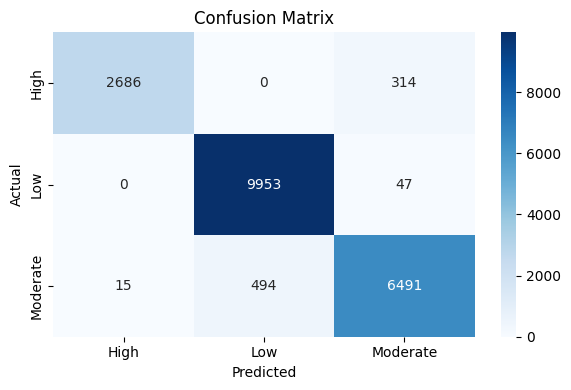

In [2]:
# STEP-0: Install required packages
# pip install catboost scikit-learn matplotlib seaborn

import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# STEP-1: Load train and test datasets
train_df = pd.read_csv("D:\\Realistic_Significant_Diabetes_100K.csv")
test_df = pd.read_csv("D:\\Test_20K.csv")

# Drop PatientID if present
if "PatientID" in train_df.columns:
    train_df = train_df.drop(columns=["PatientID"])
if "PatientID" in test_df.columns:
    test_df = test_df.drop(columns=["PatientID"])

# STEP-2: Label encode the target
le = LabelEncoder()
train_df["DiabeticRisk"] = le.fit_transform(train_df["DiabeticRisk"])
test_df["DiabeticRisk"] = le.transform(test_df["DiabeticRisk"])

# STEP-3: Define features and categorical columns
target = "DiabeticRisk"
features = [col for col in train_df.columns if col != target]
cat_features = train_df[features].select_dtypes(include='object').columns.tolist()

# STEP-4: Fix NaN/categorical string issue for CatBoost
for col in cat_features:
    train_df[col] = train_df[col].astype(str).fillna("nan")
    test_df[col] = test_df[col].astype(str).fillna("nan")

# STEP-5: Create CatBoost Pool
train_pool = Pool(train_df[features], label=train_df[target], cat_features=cat_features)
test_pool = Pool(test_df[features], label=test_df[target], cat_features=cat_features)

# STEP-6: Train CatBoost Model with custom hyperparameters
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1.0,
    rsm=0.9,
    bagging_temperature=1,
    bootstrap_type='Bayesian',
    loss_function='MultiClass',
    eval_metric='Accuracy',
    custom_metric=['F1', 'Precision', 'Recall', 'AUC'],
    od_type='Iter',
    od_wait=50,  # Early stopping if no improvement for 50 rounds
    auto_class_weights='Balanced',
    one_hot_max_size=3,
    random_seed=42,
    verbose=50
)

model.fit(train_pool, eval_set=test_pool)

# STEP-7: Predictions and Evaluation
y_pred = model.predict(test_df[features])
y_proba = model.predict_proba(test_df[features])

# Metrics
print("✅ Accuracy:", accuracy_score(test_df[target], y_pred))
print("✅ F1 Score (weighted):", f1_score(test_df[target], y_pred, average='weighted'))
print("✅ Precision (weighted):", precision_score(test_df[target], y_pred, average='weighted'))
print("✅ Recall (weighted):", recall_score(test_df[target], y_pred, average='weighted'))
print("✅ ROC AUC (OvR):", roc_auc_score(test_df[target], y_proba, multi_class='ovr'))

# Report
print("\nClassification Report:\n", classification_report(test_df[target], y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(test_df[target], y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [3]:

len(set(map(tuple, train_df.values)) & set(map(tuple, test_df.values)))


11831

In [5]:
def check_data_leakage(train_df, test_df, threshold=0.10):
    train_tuples = set(map(tuple, train_df.values))
    test_tuples = set(map(tuple, test_df.values))

    overlapping_rows = len(train_tuples & test_tuples)
    test_size = len(test_df)
    leak_ratio = overlapping_rows / test_size

    print(f"\n🔍 Overlapping rows between train and test: {overlapping_rows} out of {test_size} ({leak_ratio:.2%})")

    if leak_ratio > threshold:
        print("🚨 Data Leakage Detected! Overlap exceeds threshold.\n")
    else:
        print("✅ No significant data leakage detected.\n")
    
    return overlapping_rows

# ✅ Call the function
overlap = check_data_leakage(train_df, test_df)



🔍 Overlapping rows between train and test: 11831 out of 20000 (59.16%)
🚨 Data Leakage Detected! Overlap exceeds threshold.

